# Panorama stitching with TRWS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from cv2 import imread, imwrite, cvtColor, resize
from cv2 import COLOR_BGR2GRAY, COLOR_BGR2RGB
from cv2 import SIFT_create, BFMatcher, norm 
from cv2 import warpPerspective
from tqdm import tqdm
from time import time
from numba import njit

import funcs as f

---

# Preprocessing

### Imgs import

In [2]:
img1_clr = imread("imgs/s2a.jpg")
img2_clr = imread("imgs/s2b.jpg")
img3_clr = imread("imgs/s2c.jpg")

img1 = cvtColor(img1_clr, COLOR_BGR2GRAY)
img2 = cvtColor(img2_clr, COLOR_BGR2GRAY)
img3 = cvtColor(img3_clr, COLOR_BGR2GRAY)

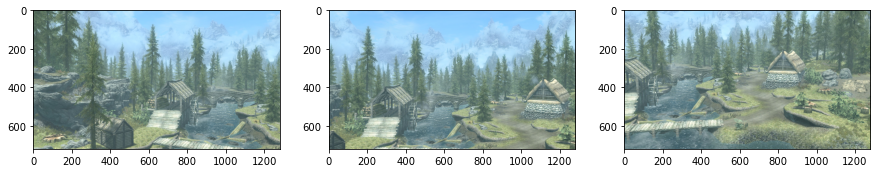

In [3]:
fig = plt.figure(figsize=(15, 12)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img1_clr, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img2_clr, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 3) 
plt.imshow(cvtColor(img3_clr, COLOR_BGR2RGB)) 

---

In [4]:
start = time()

### Homography

In [5]:
# for left part (img1, img2)
H_l = f.get_H(img2, img1)
Hinv_l = np.linalg.inv(H_l)

# for right part (img2, img3)
H_r = f.get_H(img2, img3)
Hinv_r = np.linalg.inv(H_r)

### Base creation 

In [6]:
# Base dim calculation

# source       x  y  1
s = [0,0,0,0]
s[0] = np.array([0, 0, 1])
s[1] = np.array([img2.shape[1], 0, 1])
s[2] = np.array([0, img2.shape[0], 1])
s[3] = np.array([img2.shape[1], img2.shape[0], 1])

x = np.zeros((12), dtype=np.int32)
y = np.zeros((12), dtype=np.int32)

x[0:4] = s[0][0], s[1][0], s[2][0], s[3][0]
y[0:4] = s[0][1], s[1][1], s[2][1], s[3][1]

left_p = f.warped_points(Hinv_l, s)
right_p = f.warped_points(Hinv_r, s)

x[4:8] = left_p[0][0], left_p[1][0], left_p[2][0], left_p[3][0]
x[8:12] = right_p[0][0], right_p[1][0], right_p[2][0], right_p[3][0]

y[4:8] = left_p[0][1], left_p[1][1], left_p[2][1], left_p[3][1]
y[8:12] = right_p[0][1], right_p[1][1], right_p[2][1], right_p[3][1]

x = sorted(x)
y = sorted(y)

x_min, x_max = x[0], x[-1]
y_min, y_max = y[0], y[-1]

### Warping

In [7]:
start_warp = time()
# warping left img to base
img1_warped = (f.reconstruction(img1_clr, H_l, y_max, y_min, x_max, x_min, img1.shape)).astype(np.uint8)
# warping center img to base
img2_warped = (f.reconstruction(img2_clr, np.identity(3), y_max, y_min, x_max, x_min, img1.shape)).astype(np.uint8)
# warping right img to base
img3_warped = (f.reconstruction(img3_clr, H_r, y_max, y_min, x_max, x_min, img1.shape)).astype(np.uint8)

### Results

In [8]:
print(f'Warping took: {time() - start_warp}')
print(f'Preprocessing took: {time() - start}')

Warping took: 6.570000410079956
Preprocessing took: 10.672896385192871


In [9]:
plt.imsave('base_1.png', cvtColor(img1_warped, COLOR_BGR2RGB))
plt.imsave('base_2.png', cvtColor(img2_warped, COLOR_BGR2RGB))
plt.imsave('base_3.png', cvtColor(img3_warped, COLOR_BGR2RGB))

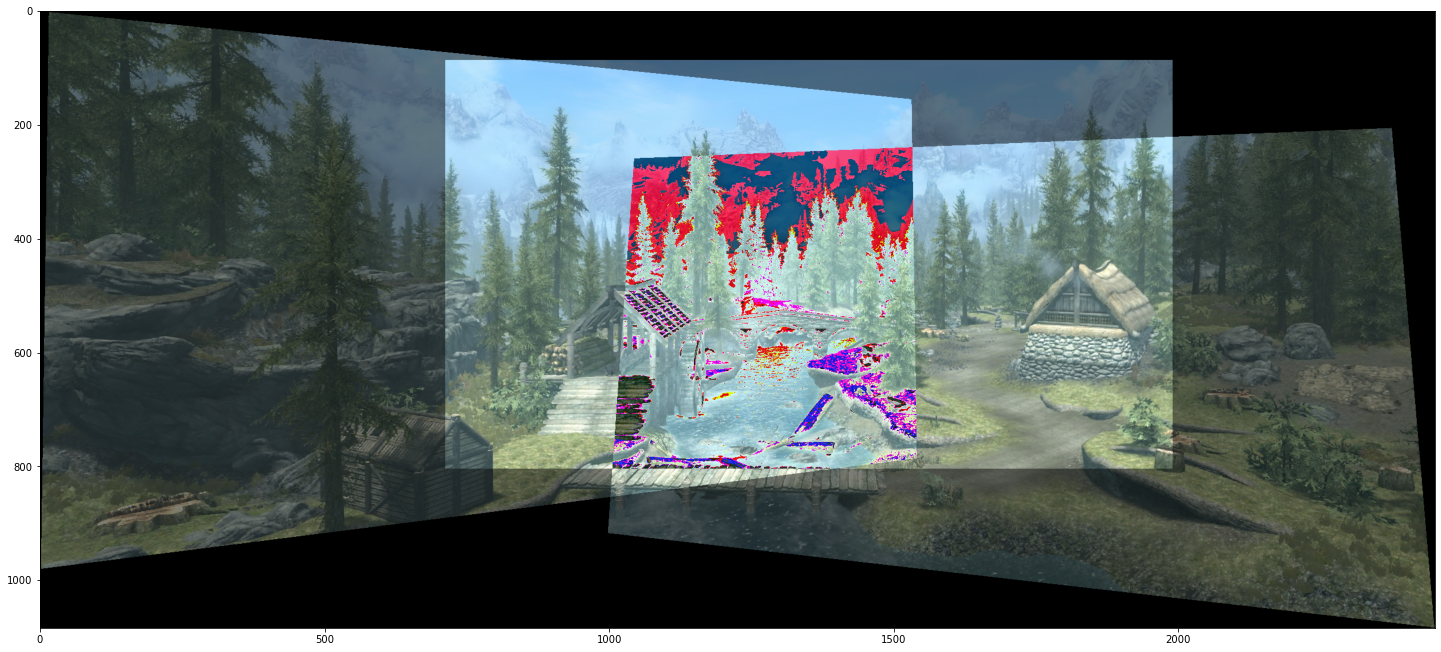

In [10]:
# Quick result check
fig = plt.figure(figsize=(25, 15)) 
foo = (0.5*img3_warped + 0.5*img2_warped + 0.5*img1_warped).astype(np.uint8)
plt.imshow(cvtColor(foo, COLOR_BGR2RGB))

---

# TRWS stitching

In [11]:
img1 = imread("base_1.png")
img2 = imread("base_2.png")
img3 = imread("base_3.png")

In [12]:
IMGS = np.array([img1.astype(np.float32), img2.astype(np.float32), img3.astype(np.float32)])
h, w = img1.shape[:2]

img1 = (img1.flatten()).astype(np.float32)
img2 = (img2.flatten()).astype(np.float32)
img3 = (img3.flatten()).astype(np.float32)

IMGS_f = [img1, img2, img3]

### TRWS init

In [13]:
start_TRWS_init = time()
# C init
C = np.array([0,1,2], dtype=np.uint8)
# Neighbours ind
N = f.initN(h,w)
# q init
q = f.init_q(IMGS, C, N, w, h)
# g init
start_g_init = time()
g = f.init_g(IMGS, C, N, w, h)
print(f'> g init took: {time() - start_g_init}')
Phi = np.zeros((len(N), len(C)))

D = np.zeros((h, w, len(C)), dtype=np.float64)
R = np.zeros((h, w, len(C)), dtype=np.float64)
    
L = np.zeros((h, w, len(C)), dtype=np.float64)
U = np.zeros((h, w, len(C)), dtype=np.float64)

D, R = f.initDR(D, R, C, N, q, g, w, h)
print(f'> TRWS init took: {time() - start_TRWS_init}')

> g init took: 34.4841947555542
> TRWS init took: 38.80321741104126


### TRWS iterations

In [14]:
start_TRWS_iter = time()
t = 10
for it in range(t):
    L, U, R, D, Phi = f.iteration(L, U, R, D, Phi, N, q, g, w, h, C)
print(f'> {t} TRWS iterations took: {time() - start_TRWS_iter}')

> 10 TRWS iterations took: 6.90399694442749


### Reconstruction

In [15]:
Res = f.reconstruct(L, R, Phi, C, q, w, h)
Img = f.render_result(Res, IMGS, w, h).astype(np.uint8)

In [16]:
print(f'> Program took: {time() - start}')

> Program took: 61.78437042236328


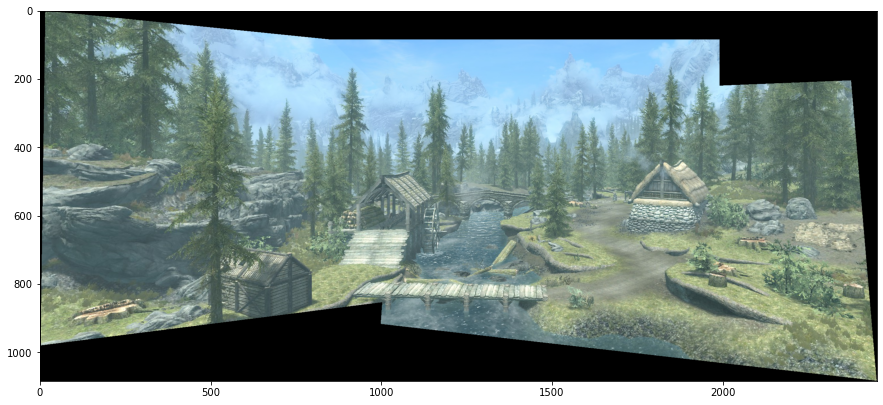

In [17]:
fig = plt.figure(figsize=(15, 15)) 
plt.imshow(cvtColor(Img, COLOR_BGR2RGB))
plt.imsave('res.png', cvtColor(Img, COLOR_BGR2RGB))